# Download data

In [1]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [2]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


In [3]:
# function for import the data .parquet to pandas dataframe
def download_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [4]:
# test/example of the import fuction
# train0 = download_data(0)
train9 = download_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [5]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [6]:
# feature selection ## select every feature except 0-4 
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]
train9[feature_cols]

#select target values
target_cols = ["responder_6"]
train9[target_cols]

#select lag values
time_cols = ["date_id","time_id"]
train9[time_cols]

# select the weight values
weight_cols = ["weight"]


## drop the other responder column

In [7]:
drop_col = [f"responder_{idx}"for idx in range(6)] + [f"responder_{idx}"for idx in range(7,9)]
train9 = train9.drop(columns= drop_col , axis= 1, errors= 'ignore')

# split the data and transfrom them into ts 

In [8]:
# create the X and Y data
def createXY(dataset,n_past):
    # n_past is the number of past tine data we want to use to predict the future
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)+1):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]-1])
            dataY.append(dataset[i-1,-1])
    return np.array(dataX),np.array(dataY) 

In [9]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

In [10]:
## i should make the scalar transformation  outside the function
# preprocess the data
def preprocessdata(df, sym_id,n_past) : # sym_id is the symbol_id of the data we want to preprocess (1-30)
    ts = df[df.symbol_id == sym_id]  
    ts = ts.drop("symbol_id",  axis = 1 , errors= "ignore") # drop the column sincce it useless in model trainng 

    # Sort the DataFrame by date_id and time_id to ensure consistent ordering
    ts = ts.sort_values(by=['date_id', 'time_id']).reset_index(drop=True)

    # Create a unique integer label in order
    ts['label'] = range(1, len(ts) + 1)

    ts = ts.apply(replace_nan_with_mean_or_zero, axis=0)

    # split the data
    test_split=round(len(ts)*0.20)
    ts_train = ts[:-test_split]
    ts_test = ts[-test_split:]

    scaler = MinMaxScaler(feature_range=(-1, 1))

    ts_train_scaled = scaler.fit_transform(ts_train[weight_cols + feature_cols +target_cols])
    ts_test_scaled = scaler.transform(ts_test[weight_cols + feature_cols + target_cols])
    print(ts_train_scaled.shape)
    
    X_train, y_train  = createXY(ts_train_scaled,n_past) # create the X and Y data for training
    X_test, y_test = createXY(ts_test_scaled,n_past) # create the X and Y data for testing

    w_test = np.array(ts_test[weight_cols])# get the weight values for the test data

    return X_train, y_train, X_test, y_test, w_test
    #return ts_train,ts_test ### dont forget to delete this line


# model 1 for symbol_id 1 LSTM

## model

In [46]:
n_past = 1
X1_train, y1_train, X1_test, y1_test, w1_test= preprocessdata(train9, 1,n_past)
n_feature = X1_train.shape[2]

w1_test = w1_test.reshape(y1_test.shape)

(128550, 81)


In [50]:
# Define the model architecture
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_past, n_feature)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Generate dummy data for demonstration
model.compile(optimizer='adam', loss='mse')

# Fit the model
model.fit(X1_train, y1_train, epochs=100, batch_size=64)

Epoch 1/100


c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2009/2009 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0243
Epoch 2/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0235
Epoch 3/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0228
Epoch 4/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0220
Epoch 5/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0217
Epoch 6/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0208
Epoch 7/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0202
Epoch 8/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0199
Epoch 9/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0197
Epoch 10/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0191
Epoch 11/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0187
Epoch 12/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0185
Epoch 13/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0181
Epoch 14/100
2009/2009 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0178
Epoch 15/100
2009/2009 ━━━━

In [54]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('1stmodel.keras')

# Verify the model is loaded by printing its summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 100)         │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,955 (2.09 MB)

 Trainable params: 182,651 (713.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 365,304 (1.39 MB)

In [55]:
y_pred = model.predict(X1_test)
r2 = r2_score(y1_test, y_pred, sample_weight= w1_test) 
print(f'R^2 Score: {r2}')

1005/1005 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
R^2 Score: -0.8101135492324829


In [52]:
# Save the model to a file
model.save('1stmodel.keras')

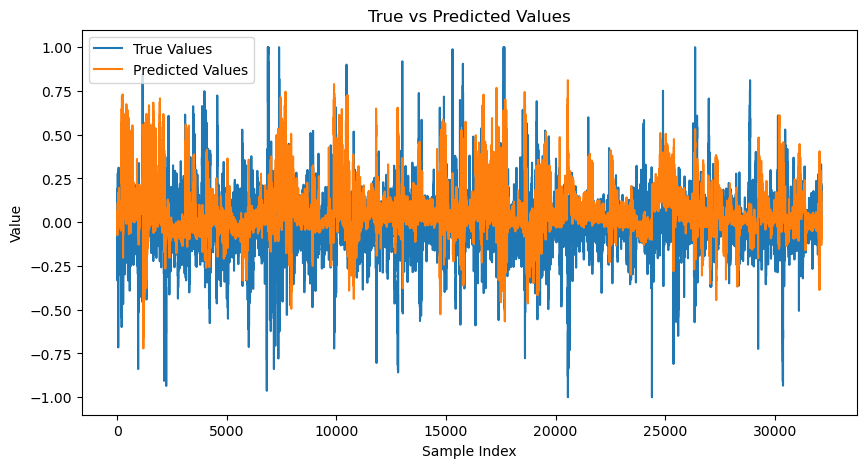

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y1_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [56]:
# create the X 
def createX(dataset,n_past):
    # n_past is the number of past tine data we want to use to predict the future
    dataX = []
    
    for i in range(n_past, len(dataset)+1):
            dataX.append(dataset[i - n_past:i])
    return np.array(dataX) 